In [1]:
using Revise

In [2]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1423


In [3]:
using PotentialFlow

In [4]:
using Plots
pyplot()

┌ Warning: Replacing module `PlotUtils`
└ @ Base loading.jl:1036


Plots.PyPlotBackend()

In [16]:
#=
struct PressureObservations{Nx,Ny,ST,CT} <: LowRankVortex.AbstractObservationOperator{Nx,Ny}
    sens::ST
    config::CT
end

function PressureObservations(sens::AbstractVector,config::VortexConfig)
    return PressureObservations{3*config.Nv,length(sens),typeof(sens),typeof(config)}(sens,config)
end

function LowRankVortex.observations(x::AbstractVector,obs::PressureObservations)
  @unpack config, sens = obs
  v = state_to_lagrange_reordered(x,config)
  return analytical_pressure(sens,v,config)
end

function LowRankVortex.jacob!(J,x::AbstractVector,obs::PressureObservations)
    @unpack config, sens = obs
    v = state_to_lagrange_reordered(x,config)
    analytical_pressure_jacobian!(J,sens,v,config)
end
=#

## Inference studies

In [5]:
using Distributions
using Random
using LinearAlgebra

In [6]:
Random.seed!(1234)

TaskLocalRNG()

### Bodies

In [7]:
a1 = 0.5; b1 = 0.1; ccoeff = ComplexF64[0.5(a1+b1),0,0.5(a1-b1)]
b = Bodies.ConformalBody(ccoeff,ComplexF64(0.0),0.0)

Body generated by: Power series map

  centroid at 0.0 + 0.0im
  angle 0.0


### Evaluation grids and sensors

#### Evaluation grid

In [8]:
rmax = 4.0   # largest radial coordinate (smallest is 1)
ϵ = 0.00001 # small offset from the surface of the unit circle
nth = 200   # number of circumferential points
dth = 2π/nth
θ = range(0,2π,length=nth+1)
dr = dth
r = [1+ϵ]
while maximum(r) < rmax
    push!(r,r[end]+dr)
    dr = r[end]*dth
end
ζg = r'.*exp.(im*θ)
zg = conftransform(ζg,b);
xg = real(zg)
yg = imag(zg)

nothing

In [9]:
# sensors on a grid
#=
xmin, xmax = -2.5, 2.5
xsens = range(xmin,xmax,length=81)
ysens = range(xmin,xmax,length=81)
zsens = xsens .+ im*ysens';
sens = vec(zsens);
=#

# sensors in a circle. For force sensors, set this to three, just to specify number.
rsens = 1.0
Nsens = 21
θsens = range(0,2π,length=Nsens+1)
sens = rsens*exp.(im*θsens[1:end-1]); # circle plane
sens_z = Bodies.conftransform(sens,b);

# sensors in lines
#lowerrow = range(-2.0,2.0,length=11) .- 0.0*im
#upperrow = range(-2.0,2.0,length=41) .+ 2.0*im
#leftside = im*range(-1.0,3.0,length=41) .- 1.0
#rightside = im*range(-1.0,3.0,length=41) .+ 1.0
#sens = vcat(lowerrow,);  #upperrow);

### Truth

In [49]:
Nv_cluster = 1
Nv_per_cluster = 5
z0 = complex(0.0)
Γ0 = 1.0
δ_true = 0.01
rr = (1.1,2.0)
θr = (0.0,π)
Γr = (0,2)
σx = 0.03
σΓ = 0.03
Nv_true = Nv_cluster*Nv_per_cluster 

ζv, Γv = createclusters(Nv_cluster,Nv_per_cluster,rr,θr,Γr,σx,σΓ;body=b,each_cluster_radius=1.5*σx)

zv = Elements.conftransform(ζv,b)

config_data_true = VortexConfig(Nv_true, δ_true, body=b)


vort = Vortex.Blob.(ζv,Γv,δ_true)
vort_z = Elements.conftransform(vort,b);

x_true = lagrange_to_state_reordered(vort,config_data_true);

In [50]:
[sum(Γv[(j-1)*Nv_per_cluster+1:j*Nv_per_cluster]) for j in 1:Nv_cluster]

1-element Vector{Float64}:
 1.359954630381209

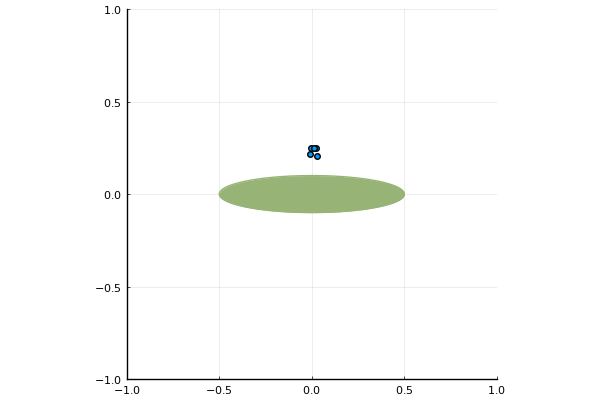

In [51]:
scatter(real.(zv),imag.(zv),ratio=1,ylim=(-1,1),xlim=(-1,1))
plot!(b)

In [52]:
ptrue_field = analytical_pressure(ζg,vort,config_data_true);

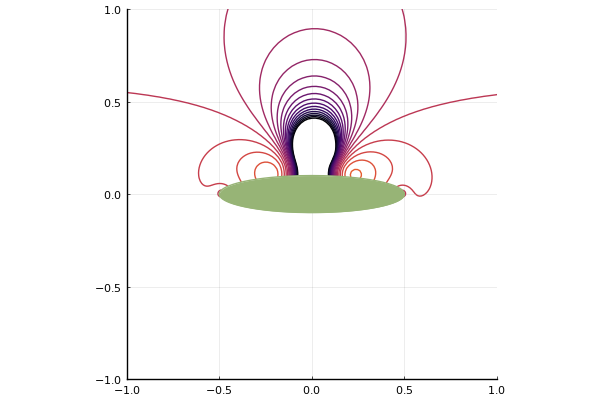

In [53]:
xmin, xmax = -1, 1
l = range(-1,1,length=31)
cl = (-1,1)
contour(xg,yg,ptrue_field,ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
plot!(b)

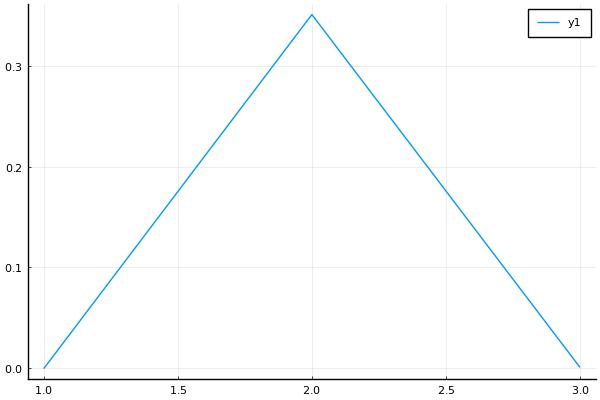

In [54]:
#obs_true = PressureObservations(sens,config_data_true);
obs_true = ForceObservations(config_data_true);
ystar = observations(x_true,obs_true);
plot(ystar)

## Single vortex estimation

In [55]:
Nv_one = 1
δ = 0.01

config_1vortex_data = VortexConfig(Nv_one, δ,body=b)

# prior
# force
ϵmeas = 1e-3 #5e-4 #1e-3
ϵr = 5e-4 #1e-4 #1e-4
ϵrθ = 5e-3 #1e-3 #3e-4
ϵΓ = 5e-3 #1e-3 #1e-4

# pressure
#ϵmeas = 5e-4 #1e-3
#ϵr = 1e-4
#ϵrθ = 3e-4
#ϵΓ = 1e-4

# ranges to confine the prior mean to
rr = (1.2,1.4)
θr = (0,2π)
Γr = (0.0,2.0)

#obs = PressureObservations(sens,config_1vortex_data);
obs = ForceObservations(config_1vortex_data);

In [56]:
sol_collection = vortexinference(ystar,rr,θr,Γr,ϵmeas,ϵr,ϵrθ,ϵΓ,obs;linear_flag=false,maxiter=150,numsample=5,inflate=true);

In [57]:
collection_err = map(x -> x[end].yerr,sol_collection)

5-element Vector{Float64}:
 0.6542224553337366
 0.8027080379142068
 0.8942082592953577
 0.8810214181189965
 0.8318573103077596

In [58]:
minerr, sampnum = findmin(collection_err)
solhist = sol_collection[sampnum];

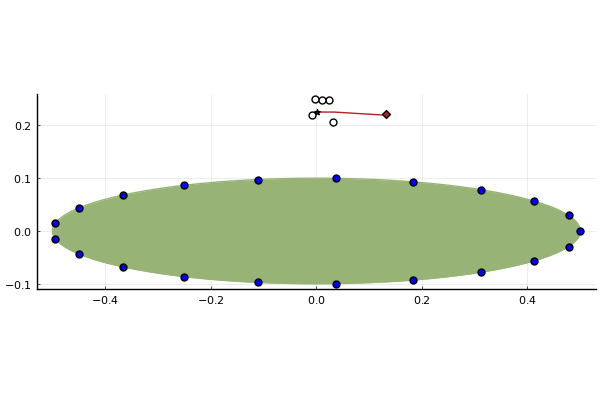

In [59]:
pl = filtertrajectory(solhist,sens_z,vort_z,config_1vortex_data,legend=false)

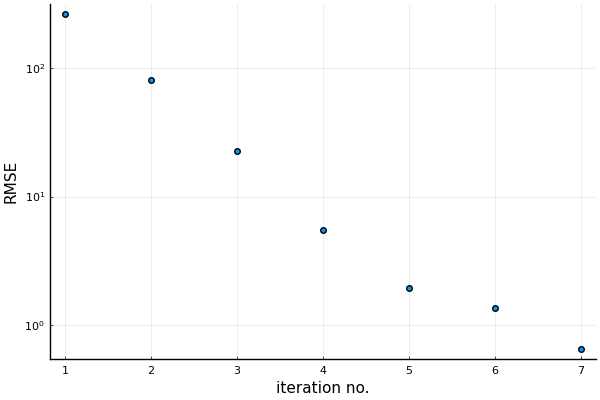

In [60]:
yerrhist = map(x -> x.yerr,solhist)
pl = scatter(yerrhist,yscale=:log10,xlabel="iteration no.",ylabel="RMSE",legend=false)

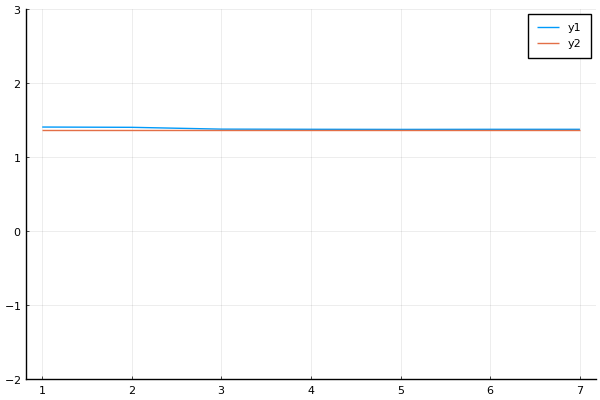

In [61]:
plot(map(x -> mean(x.X)[3],solhist),ylim=(-2,3))
plot!(sum(x_true[2Nv_true+1:3Nv_true])*ones(length(solhist)))

In [62]:
jdex = length(solhist)
vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_1vortex_data;isblob=true)
Elements.conftransform(vort_post,b)

1-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(0.001659236112233488 + 0.2253528841190551im, 1.3745065373139391, 0.01)

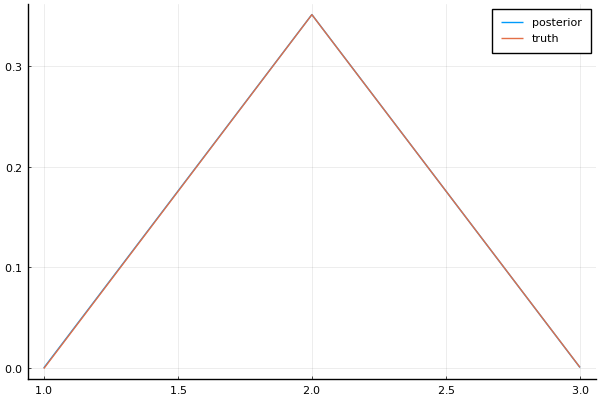

In [63]:
jdex = length(solhist)
vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_1vortex_data;isblob=true);
y_post = observations(mean(solhist[jdex].X),obs)
p_post_field = analytical_pressure(ζg,vort_post,config_1vortex_data)
plot(y_post,label="posterior")
plot!(ystar,label="truth")

In [34]:
sqrt(cov(whiten(solhist[end].X,solhist[end].Σx)))

3×3 Matrix{Float64}:
 11.7518    0.810543  0.190016
  0.810543  4.7431    0.840323
  0.190016  0.840323  0.747499

In [391]:
solhist[end].ΣX̆Y̆*inv(solhist[end].ΣY̆)

3×3 Matrix{Float64}:
 -0.736911   0.0205542    0.0646195
 -0.265123   0.0988241    0.0215133
 -0.234945  -0.000259632  0.0172619

In [392]:
solhist[end].Y̆

Ensemble with 50 members of 3-dimensional data
3×50 Matrix{Float64}:
  2.79613   0.180415   1.63686   …  -0.648393  -1.52853   -0.852389
  1.31405   0.811676   0.480943      0.826879  -1.61165   -1.29723
 -1.47491  -0.906938  -1.30281       1.06413   -0.158168  -0.961416

In [393]:
solhist[end].U

3×3 Matrix{Float64}:
  0.112555  0.522363   0.845262
 -0.96201   0.270229  -0.0388985
  0.248734  0.808772  -0.532934

In [64]:
Bodies.enforce_no_flow_through!(b,RigidBodyMotion(0.0,0.0),vort,0.0)
imp_true = Elements.impulse((b,vort))
circ_true = Elements.circulation(vort)
Bodies.enforce_no_flow_through!(b,RigidBodyMotion(0.0,0.0),vort_post,0.0)
imp_post = Elements.impulse((b,vort_post))
circ_post = Elements.circulation(vort_post)
circ_true, circ_post,imp_true, imp_post

(1.359954630381209, 1.3745065373139391, 1.6561055726914993 - 0.025111431251428055im, 1.6437066037028694 - 0.0037301132486893323im)

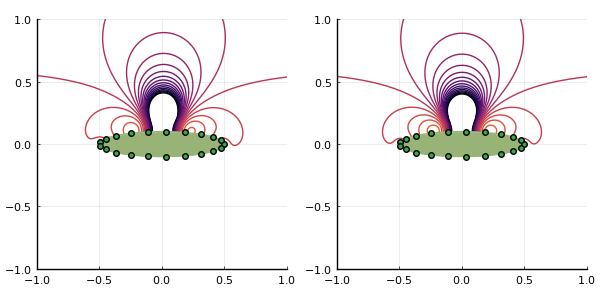

In [65]:
l = range(-1,1,length=31)
cl = (-1,1)
pl1 = contour(xg,yg,ptrue_field,ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
plot!(pl1,b)
scatter!(pl1,real.(sens_z),imag.(sens_z))
#plot!(x,y,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
pl2 = contour(xg,yg,p_post_field,ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
plot!(pl2,b)
scatter!(pl2,real.(sens_z),imag.(sens_z))
p1 = plot(pl1,pl2,size=(600,300))
#savefig("3cluster-pfield-1vortex-wall-11linesensors.pdf")

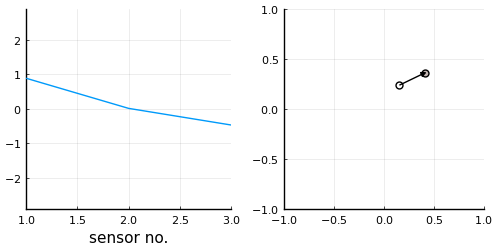

In [268]:
showmode(20,3,solhist,config_1vortex_data,size=(500,250),xlim=(-1,1),ylim=(-1,1))

### Multiple vortices

In [40]:
Nv = 2
δ = 0.01 #0.01
ϵmeas = 1e-3 #1e-3
ϵX = 5e-3 #5e-3
ϵΓ = 5e-3 #5e-2 #5e-3
Ne = 50

#config_data = VortexConfig(Nv, δ, walltype=LowRankVortex.FlatWall)
config_data = VortexConfig(Nv, δ, body=b)


Σx = Diagonal(vcat(ϵX^2*ones(Nv),ϵX^2*ones(Nv),ϵΓ^2*ones(Nv)));
Σϵ = Diagonal(ϵmeas^2*ones(length(sens)))

# ranges to confine the prior mean to
rr = (1.2,1.4)
θr = (0,2π)
Γr = (0.0,2.0)

obs = ForceObservations(config_data);

In [41]:
sol_collection = vortexinference(Nv,ystar,rr,θr,Γr,ϵmeas,ϵr,ϵrθ,ϵΓ,obs;linear_flag=false,maxiter=150,numsample=5,inflate=true);

In [43]:
collection_err = map(x -> x[end].yerr,sol_collection)

5-element Vector{Float64}:
   0.8864659514597706
  40.68398001016925
  67.06469422687621
  21.372338951149747
 109.02891126504983

In [44]:
minerr, sampnum = findmin(collection_err)
solhist = sol_collection[sampnum];

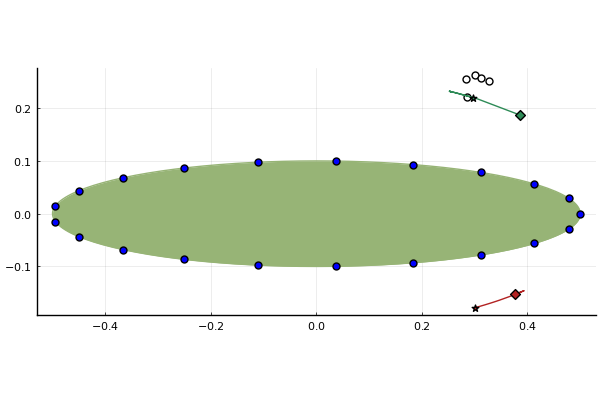

In [45]:
pl = filtertrajectory(solhist,sens_z,vort_z,config_data,legend=false,markersize=5)
#pl = filtertrajectory(solhist,sens_z,x_true,markersize=5)
#savefig("3cluster-traj-3vortex-11linesensors.pdf")

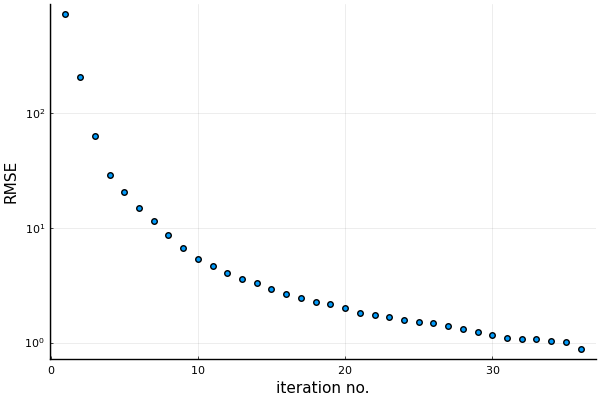

In [47]:
yerrhist = map(x -> x.yerr,solhist)
scatter(yerrhist,yscale=:log10,xlabel="iteration no.",ylabel="RMSE",legend=false)

┌ Info: Saved animation to 
│   fn = /Users/jeff/JuliaProjects/LowRankVortex/stationary/tmp.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/lW9ll/src/animation.jl:137


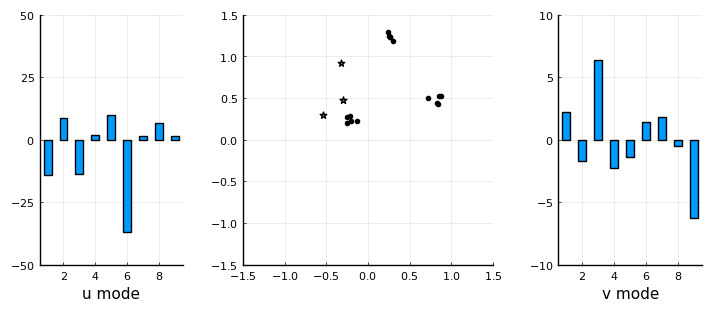

Plots.AnimatedGif("/Users/jeff/JuliaProjects/LowRankVortex/stationary/tmp.gif")
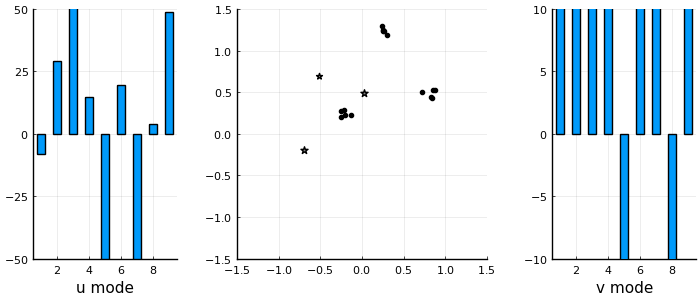

In [293]:
@gif for j in 1:length(solhist)
    filterstepplot(j,solhist,x_true,xlim=(-1.5,1.5),ylim=(-1.5,1.5),size=(700,300),arrows_on=false,ubarscale=0.1,vbarscale=0.1)
end every 1

In [3735]:
Λxmaxhist = map(x -> maximum(x.Λx),solhist);
Λxminhist = map(x -> minimum(x.Λx),solhist);

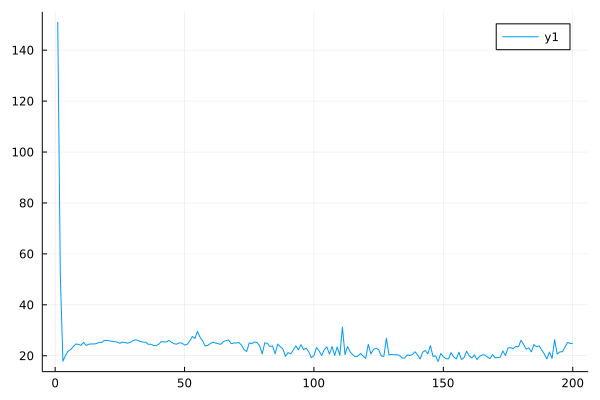

In [3736]:
plot(sqrt.(Λxmaxhist./Λxminhist))

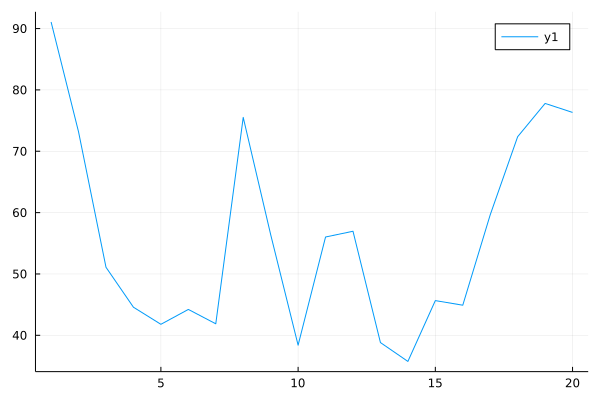

In [2868]:
Λymaxhist = map(x -> maximum(x.Λy),solhist);
Λyminhist = map(x -> minimum(x.Λy[11]),solhist);
plot(sqrt.(Λymaxhist./Λyminhist))

In [1032]:
# For plotting modes of sensors on a grid
#=
jdex = 1
V = solhist[jdex].V
U = solhist[jdex].U;
mode = 5
zv_j = Elements.position(state_to_lagrange_reordered(mean(solhist[jdex].Xf),config_data;isblob=true));

Ugrid = reshape(U[:,mode],(81,81))

maxv = 5/length(sens)
plot(xsens,ysens,Ugrid',ratio=1,legend=false,levels=range(-maxv,maxv,length=31),clim=(-maxv,maxv),xlim=(-2.5,2.5),ylim=(-2.5,2.5))
scatter!(real.(zv_j),imag.(zv_j),markersize=5,markershape=:circle,markercolor=:black)
plot(xsens[9:73],Ugrid[9:73,25])
=#

In [717]:
jdex = length(solhist)
Λ = Diagonal(sqrt.(solhist[jdex].Λx))
Λ

9×9 Diagonal{Float64, Vector{Float64}}:
 5.36884   ⋅        ⋅        ⋅        …   ⋅         ⋅         ⋅ 
  ⋅       1.83982   ⋅        ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅       1.05287   ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅        ⋅       0.861659      ⋅         ⋅         ⋅ 
  ⋅        ⋅        ⋅        ⋅            ⋅         ⋅         ⋅ 
  ⋅        ⋅        ⋅        ⋅        …   ⋅         ⋅         ⋅ 
  ⋅        ⋅        ⋅        ⋅           0.344979   ⋅         ⋅ 
  ⋅        ⋅        ⋅        ⋅            ⋅        0.327551   ⋅ 
  ⋅        ⋅        ⋅        ⋅            ⋅         ⋅        0.208736

In [722]:
inv(Λ^2+I)

9×9 Diagonal{Float64, Vector{Float64}}:
 0.0335295   ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅         0.228053   ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅          ⋅        0.474265   ⋅            ⋅         ⋅         ⋅ 
  ⋅          ⋅         ⋅        0.573903      ⋅         ⋅         ⋅ 
  ⋅          ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅          ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅          ⋅         ⋅         ⋅           0.893647   ⋅         ⋅ 
  ⋅          ⋅         ⋅         ⋅            ⋅        0.903106   ⋅ 
  ⋅          ⋅         ⋅         ⋅            ⋅         ⋅        0.958249

In [721]:
inv(solhist[jdex].ΣY̆)

9×9 Matrix{Float64}:
  0.0420401    -0.0010616  -0.000171404  …   0.0141555   0.00326242
 -0.0010616     0.14375     0.014616        -0.0250818  -0.0114332
 -0.000171404   0.014616    0.347951        -0.0344829  -0.0172207
 -0.00351684   -0.012441    0.00144629      -0.114739   -0.0345511
 -0.00377549   -0.0143413  -0.019293        -0.0729741  -0.0194355
  0.0182224     0.0124882   0.0490452    …  -0.108692   -0.147509
 -0.00896326    0.0229053   0.00709967      -0.0447372  -0.027746
  0.0141555    -0.0250818  -0.0344829        1.5497      0.0710118
  0.00326242   -0.0114332  -0.0172207        0.0710118   1.10896

In [718]:
Λ*inv(Λ^2+I)

9×9 Diagonal{Float64, Vector{Float64}}:
 0.180015   ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅        0.419577   ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅         ⋅        0.499337   ⋅            ⋅         ⋅         ⋅ 
  ⋅         ⋅         ⋅        0.494508      ⋅         ⋅         ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
  ⋅         ⋅         ⋅         ⋅        …   ⋅         ⋅         ⋅ 
  ⋅         ⋅         ⋅         ⋅           0.308289   ⋅         ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅        0.295814   ⋅ 
  ⋅         ⋅         ⋅         ⋅            ⋅         ⋅        0.200021

In [723]:
K̆ = solhist[jdex].ΣX̆Y̆*inv(solhist[jdex].ΣY̆)

9×9 Matrix{Float64}:
 -0.156281    0.0162501  -0.0784775  -0.0142543   …  -0.0398326   -0.00759577
  0.0839904  -0.36931     0.159266    0.0708149       0.0604963    0.0258808
 -0.0105751   0.175896   -0.0245319   0.664425       -0.186462    -0.0414131
 -0.249184   -0.192956    0.395542    0.180979       -0.0911877   -0.026134
 -0.0453958  -0.118877   -0.176088   -0.136194        0.00612355  -0.0588428
  0.183985    0.0154491   0.175801    0.849524    …  -0.0826283    0.010563
  0.179823   -0.207566   -0.296979   -0.132168        0.221314     0.0242041
 -0.33388    -0.14964    -0.39128    -0.00402084     -0.162845     0.101284
 -0.110313   -0.0188839  -0.171044    0.502068       -0.0942153    0.0789803

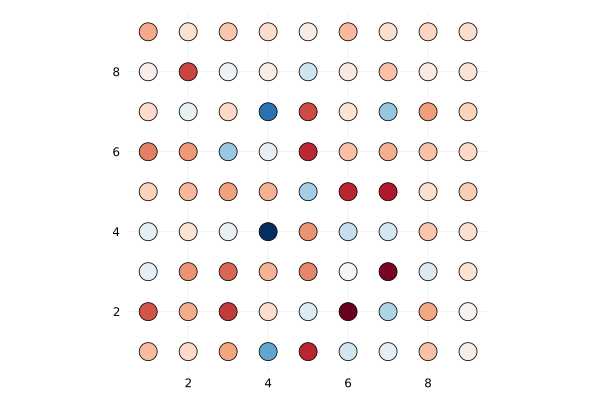

In [724]:
Iind = repeat(1:9,1,9)
Jind = repeat((1:9)',9,1);
scatter(reverse(Iind,dims=1),reverse(Jind,dims=1),ratio=1,markersize=10,marker_z=(x,y)->K̆[10-round(Int,y),round(Int,x)],markercolor=:RdBu,legend=false,xlim=(0.5,9.5),ylim=(0.5,9.5),showaxis=false)

The Kalman gain isn't diagonally dominant. Mixes U and V modes together. In particular, higher U modes affect most V modes.

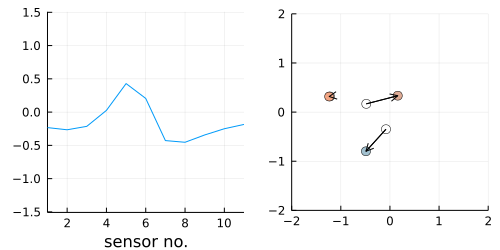

In [610]:
showmode(80,3,solhist,size=(500,250),xlim=(-2,2),ylim=(-2,2))

In [300]:
jdex = length(solhist)
vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_data;isblob=true);
zv_post = Elements.position(vort_post);
Γ_post = LowRankVortex.strength(vort_post);
y_post = analytical_pressure(sens,vort_post,b,config_data)
p_post_field = analytical_pressure(zg,vort_post,b,config_data)
vort_post

3-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(-0.3285357856706979 + 1.1261062738404113im, -1.235847366488323, 0.01)
 Vortex.Blob(-0.32015852411602597 + 0.5005225138428088im, 1.4721726848633525, 0.01)
 Vortex.Blob(-0.5508485461199494 + 0.34736677176486785im, -0.4598577216701753, 0.01)

In [1454]:
vortexmoment(1,zv_post,Γ_post)

0.1323842565617684 + 0.017687318398536378im

In [1455]:
vortexmoment(1,zv,Γv)

0.10311448912394362 - 0.023369634750555285im

In [1096]:
norm(solhist[end].X,solhist[end].Σx)

501.3953018717372

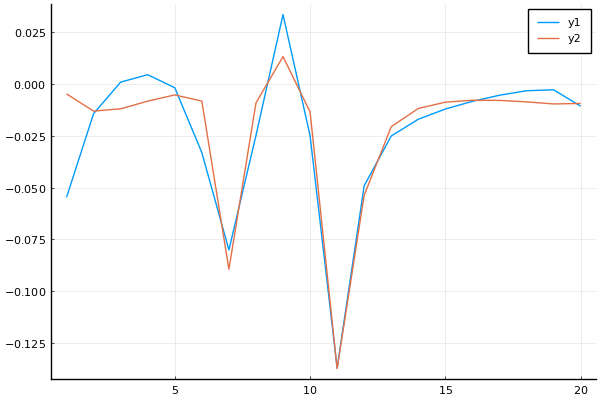

In [301]:
plot(y_post)
plot!(ystar)

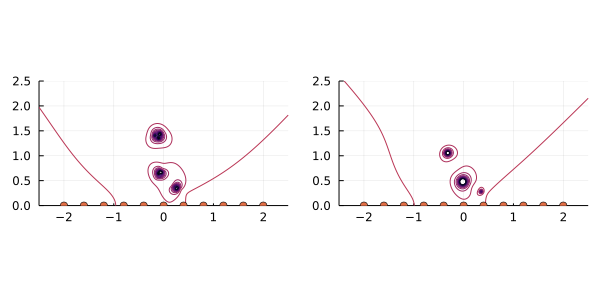

In [40]:
l = range(-1,1,length=31)
cl = (-1,1)
pl1 = plot(xg,yg,ptrue_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(0,xmax))
scatter!(pl1,real.(sens),imag.(sens))
#plot!(x,y,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
pl2 = plot(xg,yg,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(0,xmax))
scatter!(pl2,real.(sens),imag.(sens))
p1 = plot(pl1,pl2,size=(600,300))
#savefig("3cluster-pfield-3vortex-11linesensors.pdf")
display(p1)

In [1643]:
norm(ptrue_field-p_post_field)/norm(ptrue_field)

3.6547300835351115

### Explore the cost function topology
Here, we will map out the cost function's dependence on two components of the state, while
keeping the others fixed.

In [48]:
mean(solhist[jdex].X)

LoadError: BoundsError: attempt to access 36-element Vector{Any} at index [51]

In [198]:
Nv_explore = 1
config_data = VortexConfig(Nv_explore, δ,body=b)

# start with the final mean state
rmax = 1.8
rg = range(1.01,rmax,length=101)
θg = range(0,2π,length=101)

jdex = length(solhist)
xbase = mean(solhist[jdex].X)

costmap = zeros(length(θg),length(rg))
costmap_p = zeros(length(θg),length(rg))
costmap_m = zeros(length(θg),length(rg))


v_explore = 1
xbase[2Nv_explore + v_explore] = sum(x_true[2Nv_true+1:3Nv_true])

xij = copy(xbase)


for (j,rj) in enumerate(rg)
    xij[v_explore] = log(rj-1.0)
    for (i,θi) in enumerate(θg)
        xij[Nv_explore + v_explore] = θi*rj
        hx = observations(xij,analytical_force,sens,config_data)
        costmap[i,j] = norm(ystar-hx,solhist[jdex].Σy)
        xij[2Nv_explore+v_explore] = xbase[2Nv_explore+v_explore] + 0.2
        hx_p = observations(xij,analytical_force,sens,config_data)
        costmap_p[i,j] = norm(ystar-hx_p,solhist[jdex].Σy)
        xij[2Nv_explore+v_explore] = xbase[2Nv_explore+v_explore] - 0.2
        hx_m = observations(xij,analytical_force,sens,config_data)
        costmap_m[i,j] = norm(ystar-hx_m,solhist[jdex].Σy)
        xij[2Nv_explore+v_explore] = xbase[2Nv_explore+v_explore]
    end
end

In [202]:
maximum(costmap)

1000.3909730237684

In [199]:
ζg = rg'.*exp.(im*θg)
zg = conftransform(ζg,b);
xg = real(zg)
yg = imag(zg);

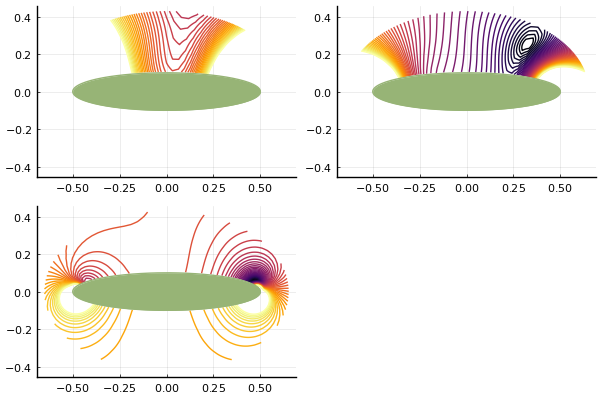

In [210]:
l = range(1.4,50,length=51)
cl=(1.4,50)
pl1 = contour(xg,yg,costmap_p,ratio=1,levels=l,clim=cl,legend=false)
plot!(pl1,b)
pl2 = contour(xg,yg,costmap,ratio=1,levels=l,clim=cl,legend=false)
plot!(pl2,b)
pl3 = contour(xg,yg,costmap_m,ratio=1,levels=l,clim=cl,legend=false)
plot!(pl3,b)
plot(pl1,pl2,pl3)

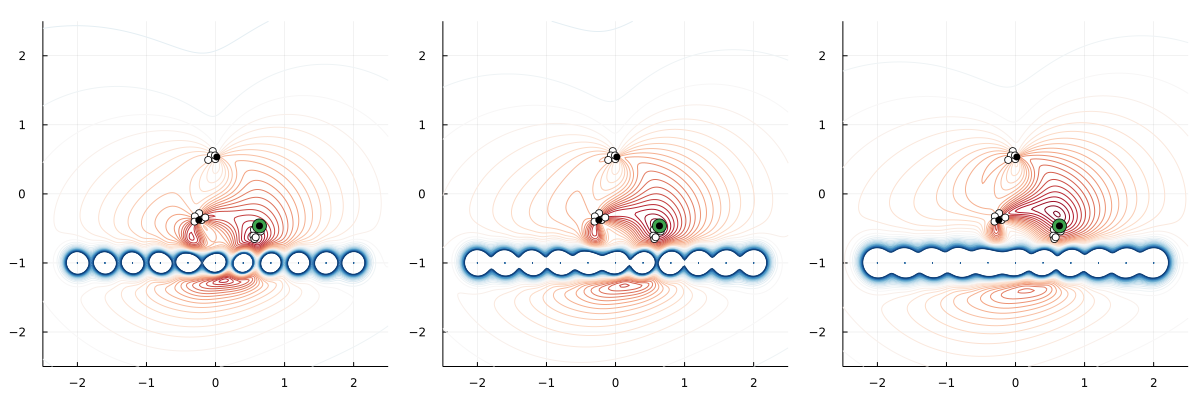

In [1592]:
truex = x_true[1:2:2Nv_true]
truey = x_true[2:2:2Nv_true]
currentx = xbase[1:2:2Nv]
currenty = xbase[2:2:2Nv]
minc = 0.3 #minimum([minimum(costmap_p),minimum(costmap),minimum(costmap_m)])
p1 = plot(xg,yg,costmap',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1,truex,truey,markercolor=:white,legend=false)
scatter!(p1,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

p1_p = plot(xg,yg,costmap_p',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1_p,truex,truey,markercolor=:white,legend=false)
scatter!(p1_p,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1_p,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

p1_m = plot(xg,yg,costmap_m',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1_m,truex,truey,markercolor=:white,legend=false)
scatter!(p1_m,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1_m,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

plot(p1_m,p1,p1_p,layout=(1,3),size=(1200,400))

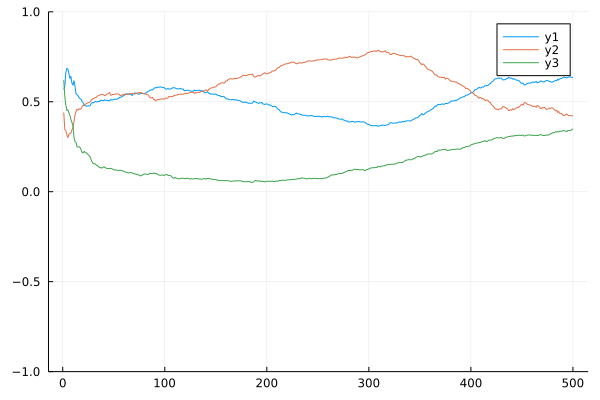

In [1571]:
plot(map(x -> mean(x.X)[2Nv+1],solhist),ylim=(-1,1))
plot!(map(x -> mean(x.X)[2Nv+2],solhist),ylim=(-1,1))
plot!(map(x -> mean(x.X)[2Nv+3],solhist),ylim=(-1,1))

In [555]:
#=
q = 10
A = zeros(q,q)
A[1,:] .= 1.0/q
for j in 2:q
    A[j,j-1] = -1.0
    A[j,j] = 1.0
end
A

i1, j1 = 3, 7
P = zeros(q,q)
for j in 1:q
    P[j,j] = 1.0
end
v = P[:,i1]
P[:,i1] .= P[:,j1]
P[:,j1] .= v
P;

dθ = Uniform(0,π)
dln = LogNormal(-2,1);;
[mean(dln) std(dln)]

dθ = Uniform(0,π)
dln = LogNormal(-2,1);
#dln = Chi(2);

q = 40
A = zeros(q,q)
A[1,:] .= 1.0/q
for j in 2:q
    A[j,j-1] = -1.0
    A[j,j] = 1.0
end
A

x̃, ỹ = zeros(q), zeros(q)
for j in 2:q
    zj = rand(dln)*exp(im*rand(dθ))
    x̃[j] = real(zj)
    ỹ[j] = imag(zj)
end

x = inv(A)*x̃;
y = inv(A)*ỹ;
scatter(x,y,ratio=1)
=#

In [302]:
dy̆ = hcat(map(x -> vcat(mean(x.Y̆),zeros(6-length(mean(x.Y̆)))),solhist)...);

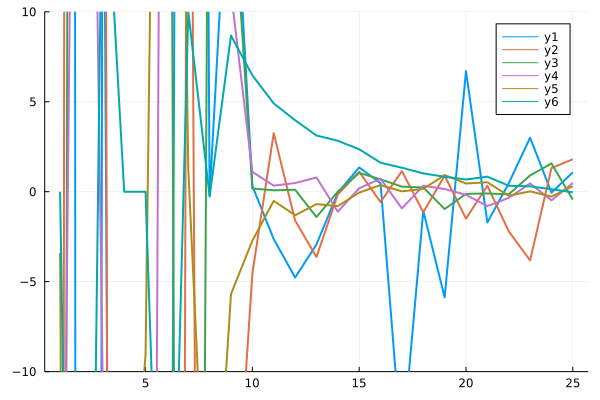

In [312]:
plot(dy̆[1,:],linewidth=2,ylim=(-10,10))
plot!(dy̆[2,:],linewidth=2)
plot!(dy̆[3,:],linewidth=2)
plot!(dy̆[4,:],linewidth=2)
plot!(dy̆[5,:],linewidth=2)
plot!(dy̆[6,:],linewidth=2)

In [290]:
dx̆ = hcat(map(x -> mean(x.ΣX̆Y̆*(x.ΣY̆\x.Y̆)),solhist)...);

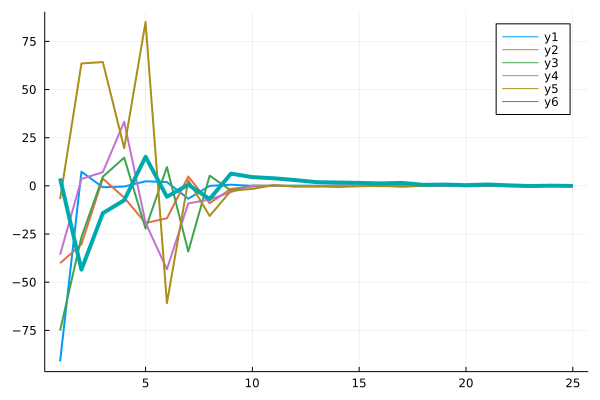

In [306]:
plot(dx̆[1,:],linewidth=2)
plot!(dx̆[2,:],linewidth=2)
plot!(dx̆[3,:],linewidth=2)
plot!(dx̆[4,:],linewidth=2)
plot!(dx̆[5,:],linewidth=2)
plot!(dx̆[6,:],linewidth=4)

In [79]:
sqrt(Σx)*Fhist[end].V[:,1:rhist[end]]*K̃*ỹhist[end]

9-element Vector{Float64}:
  0.0018490395330256174
 -0.005118568346242631
 -0.00357188260657286
 -0.00446458150403976
  0.008487842822575746
  0.007777494563758844
  0.0025521443428678826
  0.0045746465120252025
  0.0025497897622294495

36-element Vector{Float64}:
 1321.9159271767949
  197.92969822660362
   60.65322971203477
   14.070451613159014
    2.524231697075501
    0.08879175290868446
    0.0024909038486424285
    0.0003641957099004161
    8.743238899015276e-5
    1.1374831855011818e-5
    1.1561468627527092e-6
    6.920089409510231e-9
    2.6473141167366238e-9
    ⋮
    2.4868995751603507e-14
    2.259396132881637e-14
    1.4422580366206255e-14
    1.4210854715202004e-14
    1.0552812029956029e-14
    9.978272503795993e-15
    9.166656117039269e-15
    7.54697596667468e-15
    7.105427357601002e-15
    5.985093828153431e-15
    5.80939686960131e-15
    4.273885897591831e-15

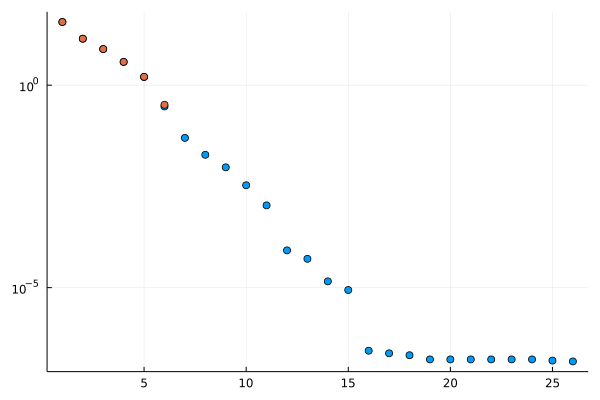

In [218]:
Λx = solhist[end].Λx[solhist[end].Λx.>100*eps()]
Λy = solhist[end].Λy[solhist[end].Λy.>100*eps()]
pl = scatter(sqrt.(Λy),yscale=:log10,legend=false)
scatter!(pl,sqrt.(Λx),yscale=:log10,legend=false)

#savefig("4vortex-svalues.pdf")
#savefig("4vortex-svalues.png")
display(pl)

In [98]:
LowRankVortex.P

9×9 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0459763   0.180721    -0.466078   -0.664597   …  -0.231686    0.0589482
  0.0788804   0.00428573   0.5093      0.0835935      0.144961    0.278253
  0.16449    -0.0732933   -0.140497    0.307257      -0.443203    0.0570702
  0.826368   -0.026383    -0.299224    0.252782      -0.0776115  -0.0232306
 -0.231958    0.659137    -0.13104     0.492813       0.098887    0.0212657
 -0.0686195   0.535204    -0.0629612   0.0229107  …  -0.31879    -0.054013
 -0.0602487  -0.0762433   -0.49928     0.106125       0.689798   -0.213156
 -0.280826   -0.279705    -0.361859    0.22372       -0.0813069   0.771225
 -0.375122   -0.395349    -0.112926    0.297177      -0.359191   -0.521258

In [99]:
V[1:2,1] + V[4:5,1] + V[7:8,1]

2-element Vector{Float64}:
  0.7201431166604436
 -0.43390344986838764

In [961]:
unitvec = zeros(length(x_post))
unitvec[6] = 1.0
F.Vt*unitvec

6-element Vector{Float64}:
  0.574771771360253
  0.22247709382174288
 -0.3319587477794311
  0.11918085260192823
 -0.24380484125187668
  0.6605299895538166

In [1318]:
F.V[:,1]

9-element Vector{Float64}:
 -0.0013365146346376764
 -0.3437027395751458
  0.0829705149437211
 -0.3194680056247702
 -0.08144756026540528
 -0.32315728742537086
  0.259381193123849
  0.5453208346181756
  0.5451650888170947

In [1319]:
cumsum(F.S)/sum(F.S)

9-element Vector{Float64}:
 0.5459333120939325
 0.7545316235684618
 0.8396933430067108
 0.9155493243748806
 0.9677749179838403
 0.9879966879557416
 0.9990439288567136
 0.9997043000270978
 0.9999999999999999